Use the plots below to tune lowerInterfaceBotGuess, lowerInterfaceTopGuess, 
         upperInterfaceBotGuess, and upperInterfaceTopGuess
Green Line  = Lower Material Interface
Organe Line = Upper Material Interface


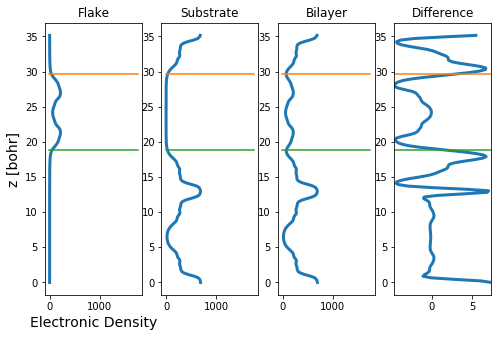


Raw Charge Transfers:
[[-0.8887448976750492, -0.8628516398411658, -0.8582595141350563, -0.8675181296729585], [-1.1739659841155112, -1.1814522481076855, -1.177412627586923, -1.1843420669014888], [-1.481895956023613], [-1.7745254745702403]]
Averaged Charge Transfers per La:
[0.21733588633276435, 0.19654887194631704, 0.1852369945029516, 0.17745254745702405]
Upper and Lower Confidence:
maxCT_perR-maxCT_perR = [0.004850338085997941, 0.0008414725372644372, 0.0, 0.0]
avgCT_perR-minCT_perR = [0.0027710077990002746, 0.0008878745937318244, 0.0, 0.0]
Bulk Charge Transfer = 0.14921513034753686 ± 0.0014110482986270172 electrons


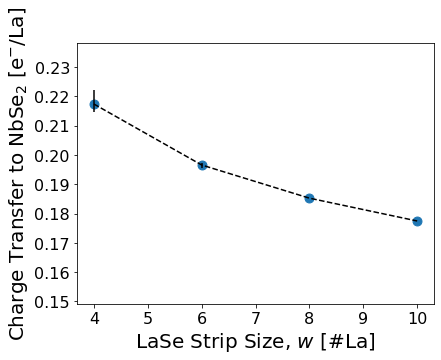

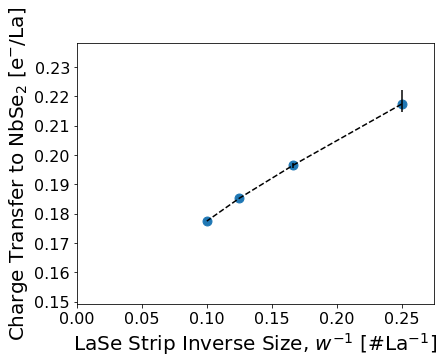

Averaged Interlayer Binding Energies per La:
[-0.09551341377088818, -0.09441559343148735, -0.09147759934845112, -0.09019697070789334]
Upper and Lower Confidence:
maxBE_perR-avgBE_perR = [0.0009542746374648914, 0.0012537005919739386, 0.0, 0.0]
avgBE_perR-minBE_perR = [0.0008597708578150787, 0.001247631016250722, 0.0, 0.0]
Bulk Interlayer Binding Energy = -2.276838612894456 ± 0.018563343342762287 [eV]


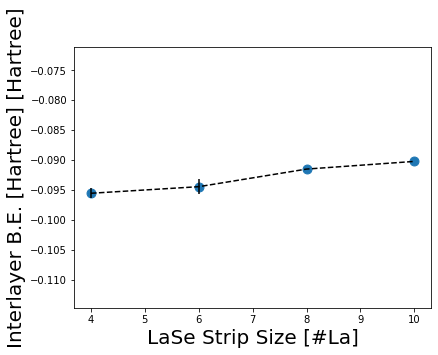

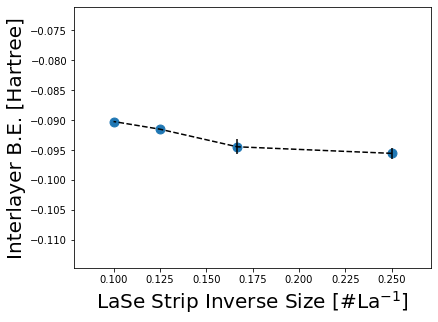

In [15]:
# Electron density reading code adapted from JDFTx tutorial
# https://jdftx.org/Outputs.html
import numpy as np
import re
import matplotlib.pyplot as plt

# The user sets the following variables 
#############################################################################
MINTpath = ""  # Folder that contains the flakeDirs
nSubsLayers = 2                          # Number of substrate layers
flakeSizes = [4,6,8,10]                  # Number of atoms of interest (e.g. Ru for RuCl3) per flake
flakeDirs = ["/4Site","/6Site","/8Site","/10Site"] # Names of dirs in MINTpath, must match length of flakeSizes
shiftDirs = ["/shift000","/shift025","/shift050","/shift075"] # sub dirs for different flake displacement/orientations
# Make sure that shiftDirs is the union of the set of sub dir names over all flakeDirs

# Mark True if your spin up and spin down electron densities are split into two separate files 
#    Also make sure to edit "nfile_up" and "nfile_dn"
spinPolar = False 

outfile = "/totalE.out"       # All .out files must have this name
nfile = "/totalE.n"           # All .n files must have this name
nfile_up = "/totalE.n_up"     # All .n_up files must have this name  (only need if spinPolar = True)
nfile_dn = "/totalE.n_dn"     # All .n_dn files must have this name  (only need if spinPolar = True)
latfile = "/system.lattice"   # All .lattice files must have this name
ionposfile = "/system.ionpos" # All .ionpos files must have this name
# each MINTpath/flakeDir/shiftDir has these 3 folders for the full bilayer, isolated flake, and isolated substrate
# 
BL_dir = "/Bilayer"
Flake_dir = "/isolated_Flake"   
Subs_dir = "/isolated_Subs"  

# Interface cutoff ranges:
# You will almost certainly have to change these for your system
# The interface btw the flake and the substrate is defined as the place where the total
#   electron density takes a minimum btw the two layers
# These four variables determine the bounds where the code will look for those interfaces
# units = fraction of unit cell height
lowerInterfaceBotGuess = 0.00  
lowerInterfaceTopGuess = 0.33 
upperInterfaceBotGuess = 0.75 
upperInterfaceTopGuess = 1.00 

# Plotting Labels
R_name = 'C'          # Name of the atomic species you report charge transfer in (e.g. R_name='C' -> dQ = 0.1 e-/C)
Subs_name = 'graphene' # Name of the periodic substrate material
Flake_name = 'RuCl$_3$'    # Name of the flake material

# Plots: Axis Label, Tick Font Size, Figure Size
fs = 20
fs_tick = 16
figsize = (8*0.8,6*0.8) 
############################################################################

# Total electron density files
outfilename_tot = BL_dir+outfile
densityfilename_tot = BL_dir+nfile
densityfilename_tot_up = BL_dir+nfile_up       
densityfilename_tot_dn = BL_dir+nfile_dn       
# Flake Electron Density files
outfilename_flake = Flake_dir+outfile
densityfilename_flake = Flake_dir+nfile
densityfilename_flake_up = Flake_dir+nfile_up  
densityfilename_flake_dn = Flake_dir+nfile_dn  
# Substrate Electron Density files
outfilename_subs = Subs_dir+outfile
densityfilename_subs = Subs_dir+nfile
densityfilename_subs_up = Subs_dir+nfile_up 
densityfilename_subs_dn = Subs_dir+nfile_dn 

# return a list of all lines in filename with pattern
def grep(pattern, filename):
    retval = [] 
    foundPattern = False
    file = open(filename, "r")
    for line in file:
        if re.search(pattern, line):
            retval.append(line)
            foundPattern = True
    if not foundPattern:
        print("grep failed to find:", pattern, "in", filename)
        print("returning an empty list")
    return retval

def finalFreeEnergy(filename):
    return float(grep("F =",filename)[0].split()[2])

def get_ionpos_ionsp(path2file):
    ionspecies = []
    ionpos = []
    with open(path2file,'r') as file:
        # Skip the comment line at the top of the file
        line = file.readline()
        # record ionspecies, and lattice coordinate
        while line:
            line = file.readline()
            line_text = line.split()
            if len(line_text) > 0:
                if line_text[0] == "ion":
                    ionspecies.append(line_text[1])
                    ionpos.append([float(x) for x in line_text[2:5]])
    return ionpos,ionspecies  

def get_LatticeMatrix(path2file):
    LatticeMatrix = []
    with open(path2file,'r') as file:
        # skip the "lattice \" line
        #line = file.readline()
        line = file.readline()
        # get the contents as a list of lines
        contents = file.readlines()
        LM = [line.split()[:3] for line in contents]
        LatticeMatrix = np.array([ [float(i) for i in lm] for lm in LM ])
    return LatticeMatrix

# Looks for the minima in the Bilayer Electron density
# to determine where the RS flake ends and the TMD substrate begins
# z_min and z_max are initial guesses
def get_flake_range(n_BL,a,b,c,d):
    z_bot = n_BL.index(min(n_BL[a:b]))
    z_top = n_BL.index(min(n_BL[c:d]))
    return z_bot,z_top
    
# returns the total electron transfer onto the flake  
def get_tot_dQ(diff,flake_bot,flake_top,dV):
    # Sum together the charge transfer from the average value bins
    tot_dQ = np.sum(diff[flake_bot:flake_top]) * dV
    return tot_dQ

def get_CT(path,nSubsLayers,debug=False):
    LM = get_LatticeMatrix(path+BL_dir+latfile)
    ionpos,ionsp = get_ionpos_ionsp(path+BL_dir+ionposfile)
    a,b,c = LM.T
    cs = np.cross(a,b)/np.linalg.norm(np.cross(a,b)) # orthogonal to a and b
    Lz = np.dot(c,cs)  # bohr , for plotting purposes
    ionpos = np.matmul(ionpos,np.transpose(LM))
    NR = ionsp.count(str(ionsp[0]))
    NT = ionsp.count(str(ionsp[NR]))
    Y1z = float(np.dot(ionpos[NR+NT  ],cs)) % Lz 
    Y2z = float(np.dot(ionpos[NR+NT+1],cs)) % Lz 
    R1z = float(np.dot(ionpos[0],cs)) % Lz
    R2z = float(np.dot(ionpos[1],cs)) % Lz 
    X1z = float(np.dot(ionpos[-1],cs)) % Lz 
    X2z = float(np.dot(ionpos[-2],cs)) % Lz 
    atomPlanes = [0.0,Y1z,R1z,X1z,X2z,R2z,Y2z]
    
    if spinPolar:
        n_tot_up = np.fromfile(path+densityfilename_tot_up,   # read from binary file
                  dtype=np.float64)      # as 64-bit (double-precision) floats
        #n = swapbytes(n)                # uncomment on big-endian machines; data is always stored litte-endian
        n_tot_dn = np.fromfile(path+densityfilename_tot_dn,   # read from binary file
                  dtype=np.float64)      # as 64-bit (double-precision) floats
        #n = swapbytes(n)                # uncomment on big-endian machines; data is always stored litte-endian
        n_tot = n_tot_up + n_tot_dn

        n_flake_up = np.fromfile(path+densityfilename_flake_up,   # read from binary file
                  dtype=np.float64)      # as 64-bit (double-precision) floats
        #n = swapbytes(n)                # uncomment on big-endian machines; data is always stored litte-endian
        n_flake_dn = np.fromfile(path+densityfilename_flake_dn,   # read from binary file
                  dtype=np.float64)      # as 64-bit (double-precision) floats
        #n = swapbytes(n)                # uncomment on big-endian machines; data is always stored litte-endian
        n_flake = n_flake_up + n_flake_dn

        n_subs_up = np.fromfile(path+densityfilename_subs_up,   # read from binary file
                  dtype=np.float64)      # as 64-bit (double-precision) floats
        #n = swapbytes(n)                # uncomment on big-endian machines; data is always stored litte-endian
        n_subs_dn = np.fromfile(path+densityfilename_subs_dn,   # read from binary file
                  dtype=np.float64)      # as 64-bit (double-precision) floats
        #n = swapbytes(n)                # uncomment on big-endian machines; data is always stored litte-endian
        n_subs = n_subs_up + n_subs_dn
    else:
        n_tot = np.fromfile(path+densityfilename_tot,   # read from binary file
                  dtype=np.float64)      # as 64-bit (double-precision) floats
        #n = swapbytes(n)                # uncomment on big-endian machines; data is always stored litte-endian
        n_flake = np.fromfile(path+densityfilename_flake,   # read from binary file
                  dtype=np.float64)      # as 64-bit (double-precision) floats
        #n = swapbytes(n)                # uncomment on big-endian machines; data is always stored litte-endian

        n_subs = np.fromfile(path+densityfilename_subs,   # read from binary file
                  dtype=np.float64)      # as 64-bit (double-precision) floats
    #n = swapbytes(n)                # uncomment on big-endian machines; data is always stored litte-endian
    ns = [n_tot,n_flake,n_subs]
    ofs = [outfilename_tot,outfilename_flake,outfilename_subs]

    n = n_tot
    outfilename = outfilename_tot
    #look for the first instance of the following in the output file
    #unit cell volume =
    #Chosen fftbox size, = 
    S = []
    V = 0
    flag = 0
    with open(path+outfilename,'r') as file:
        line = file.readline()
        #print(line)
        while line:
            line = file.readline()
            contents = line.split()
            #
            if len(contents) > 0:
                if contents[0] == "unit":
                    V = float(contents[4])
                    flag += 1
                elif contents[0] == "Chosen":
                    S = [int(contents[6]),int(contents[7]),int(contents[8])]
                    flag += 1

            if flag >= 2:
                break                          
    dV = V / np.prod(S)

    # Total Bilayer electron density
    n_tot_slices = []
    for z in range(S[2]):
        nz = n_tot.reshape(S)[:,:,z]
        # Sum up the electron density
        # choose a xy slice slice of the electron density
        slicedensity = np.sum(nz)
        # add it to an array for plotting
        n_tot_slices.append(slicedensity)

    # Sum of isolated_flake and isolated_substrate electron densities    
    n_flake_slices = []
    n_subs_slices = []
    n_sum_slices = []
    for z in range(S[2]):
        nz_flake = n_flake.reshape(S)[:,:,z]
        nz_subs  = n_subs.reshape(S)[:,:,z]
        # Sum up the electron density
        # choose a xy slice slice of the electron density
        density_flake = np.sum(nz_flake)
        density_subs = np.sum(nz_subs)
        # add it to an array for plotting
        n_flake_slices.append(density_flake)
        n_subs_slices.append(density_subs)
        n_sum_slices.append(density_flake+density_subs)
        
    # Average charge difference as a function of z    
    diff = [n_tot_slices[i]-n_sum_slices[i] for i in range(S[2])]
    
    # Interface cutoffs are the minima of the total electron density in
    #  the ranges specified by the user
    a = int(lowerInterfaceBotGuess * len(n_tot_slices))
    b = int(lowerInterfaceTopGuess * len(n_tot_slices))
    c = int(upperInterfaceBotGuess * len(n_tot_slices))
    d = int(upperInterfaceTopGuess * len(n_tot_slices))
    flake_bot,flake_top = get_flake_range(n_tot_slices,a,b,c,d)
    
    if debug:
        zbot = flake_bot*Lz/S[2]
        ztop = flake_top*Lz/S[2]
        z_plot = np.arange(0,Lz,Lz/S[2])
        
        fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(8, 5))
        titles = ["Flake","Substrate","Bilayer","Difference"]
        n_data = [n_flake_slices,n_subs_slices,n_tot_slices,diff]
        axes[0].set_xlabel("Electronic Density",fontsize=14)
        axes[0].set_ylabel("z [bohr]",fontsize=14)
        axes[3].set_xlim([np.min(diff), np.max(diff)])
        for i in range(4):
            axes[i].plot(n_data[i],z_plot,linewidth=3)
            axes[i].set_title(titles[i])
            axes[i].plot((-5,1750),(ztop,ztop))
            axes[i].plot((-5,1750),(zbot,zbot))
        #fig.tight_layout()
        plt.show()

    # Sum up the charge difference on the flake
    return get_tot_dQ(diff,flake_bot,flake_top,dV)
    
def get_BE(path):
    E_bl  = finalFreeEnergy(path+BL_dir+outfile)
    E_rs  = finalFreeEnergy(path+Flake_dir+outfile)
    E_tmd = finalFreeEnergy(path+Subs_dir+outfile)
    return E_bl - (E_rs + E_tmd)

print("""Use the plots below to tune lowerInterfaceBotGuess, lowerInterfaceTopGuess, 
         upperInterfaceBotGuess, and upperInterfaceTopGuess""")
print("Green Line  = Lower Material Interface")
print("Organe Line = Upper Material Interface")

flag = True # for plotting one debug plot
CTs = [] # Charge Transfers
BEs = [] # Binding Energies
for flakeDir in flakeDirs:
    CTs_flake = []
    BEs_flake = []
    for shiftDir in shiftDirs:
        path = MINTpath+flakeDir+shiftDir
        # Not all flake dirs have all the shiftDirs, account for this
        try:
            CT = get_CT(path,nSubsLayers,debug=flag)
            CTs_flake.append(CT)
            BE = get_BE(path)
            BEs_flake.append(BE)
        except:
            print("Warning: Couldn't compute either CT or BE in", path)
        if flag:
            flag = False
    CTs.append(CTs_flake)
    BEs.append(BEs_flake)

print("")
print("Raw Charge Transfers:")
print(CTs)

# Plot wrt inverse flake size and fit line to the converging datapoints
# The converged charge transfer will be the y-intercept
inv_flakeSizes = 1.0/np.array(flakeSizes)

# Plot the charge transfer v.s. Flake Size
CT_perR = [ [-1*np.array(CTs[i])/flakeSizes[i]] for i in range(len(flakeSizes))]
avgCT_perR = [np.mean(ctf) for ctf in CT_perR]
maxCT_perR = [np.max(ctf)-np.mean(ctf) for ctf in CT_perR]
minCT_perR = [np.mean(ctf)-np.min(ctf) for ctf in CT_perR]
print("Averaged Charge Transfers per "+R_name+":")
print(avgCT_perR)
print("Upper and Lower Confidence:")
print("maxCT_perR-maxCT_perR =", maxCT_perR)
print("avgCT_perR-minCT_perR =", minCT_perR)
# Extract Bulk Charge Transfer from linear fit
dataCut = -3 # only linfit to the last "this many" points
p_linfit,p_cov = np.polyfit(inv_flakeSizes[dataCut:],avgCT_perR[dataCut:], 1,cov=True)
p = np.poly1d(p_linfit)
print("Bulk Charge Transfer =", p_linfit[1], u"\u00B1" , np.sqrt(p_cov[1][1]), "electrons")


# PLOT: Charge Transfers v.s. Flake Size
plt.figure(figsize=figsize)
plt.scatter(flakeSizes,avgCT_perR,s=80)
plt.errorbar(flakeSizes,avgCT_perR, yerr=[minCT_perR,maxCT_perR], fmt='k--')
plt.xlabel(Flake_name+' Strip Size, $w$ [#'+R_name+']',fontsize=fs)
plt.ylabel('Charge Transfer to '+Subs_name+' [e$^{-}$/'+R_name+']',fontsize=fs)
plt.ylim((p_linfit[1],None))
plt.xticks(fontsize=fs_tick, rotation=0)
plt.yticks(fontsize=fs_tick, rotation=0)
plt.show()


# PLOT: Charge Transfers v.s. Inverse Flake Size
plt.figure(figsize=figsize)
plt.scatter(inv_flakeSizes,avgCT_perR,s=80)
# uncomment below to plot linear fit to the data in the "dQ v.s. inverse flake size" plot
#plt.plot([0,inv_flakeSizes[dataCut]],[p(0),p(inv_flakeSizes[dataCut])],c='black',linestyle='--')
plt.errorbar(inv_flakeSizes,avgCT_perR, yerr=[minCT_perR,maxCT_perR], fmt='k--')
plt.xlabel(Flake_name+' Strip Inverse Size, $w^{-1}$ [#'+R_name+'$^{-1}$]',fontsize=fs)
plt.ylabel('Charge Transfer to '+Subs_name+' [e$^{-}$/'+R_name+']',fontsize=fs)
plt.xlim((0,0.275))
plt.ylim((p_linfit[1],None))
plt.xticks(fontsize=fs_tick, rotation=0)
plt.yticks(fontsize=fs_tick, rotation=0)
plt.show()


BE_perR = [ [np.array(BEs[i])/flakeSizes[i]] for i in range(len(flakeSizes))]
avgBE_perR = [np.mean(ctf) for ctf in BE_perR]
maxBE_perR = [np.max(ctf)-np.mean(ctf) for ctf in BE_perR]
minBE_perR = [np.mean(ctf)-np.min(ctf) for ctf in BE_perR]
print("Averaged Interlayer Binding Energies per "+R_name+":")
print(avgBE_perR)
print("Upper and Lower Confidence:")
print("maxBE_perR-avgBE_perR =", maxBE_perR)
print("avgBE_perR-minBE_perR =", minBE_perR)
# Extract Bulk Binding Energies from linear fit
dataCut = -3 # only linfit to the last "this many" points
p_linfit,p_cov = np.polyfit(inv_flakeSizes[dataCut:],avgBE_perR[dataCut:], 1,cov=True)
p = np.poly1d(p_linfit)
print("Bulk Interlayer Binding Energy =", p_linfit[1]*27.2114, u"\u00B1" , np.sqrt(p_cov[1][1])*27.2114, "[eV]")

# PLOT: Binding Energies v.s. Flake Size
plt.figure(figsize=figsize)
plt.scatter(flakeSizes,avgBE_perR,s=80)
plt.errorbar(flakeSizes,avgBE_perR, yerr=[minBE_perR,maxBE_perR], fmt='k--')
plt.xlabel(Flake_name+' Strip Size [#'+R_name+']',fontsize=fs)
plt.ylabel('Interlayer B.E. [Hartree] [Hartree]',fontsize=fs)
plt.show()


# PLOT: Binding Energies v.s. Inverse Flake Size
plt.figure(figsize=figsize)
plt.scatter(inv_flakeSizes,avgBE_perR,s=80)
# uncomment below to plot linear fit to the data in the "BE v.s. inverse flake size" plot
#plt.plot([0,inv_flakeSizes[dataCut]],[p(0),p(inv_flakeSizes[dataCut])])
plt.errorbar(inv_flakeSizes,avgBE_perR, yerr=[minBE_perR,maxBE_perR], fmt='k--')
plt.xlabel(Flake_name+' Strip Inverse Size [#'+R_name+'$^{-1}$]',fontsize=fs)
plt.ylabel('Interlayer B.E. [Hartree]',fontsize=fs)
plt.show()
